In [ ]:
!pip install -qU langchain-groq langchain langchain-community langgraph qdrant-client sentence-transformers

In [ ]:
import os
from google.colab import userdata
from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.vectorstores import Qdrant
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.documents import Document
from langgraph.graph import END, StateGraph
from typing import List, TypedDict

os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')

llm = ChatGroq(temperature=0, model_name="openai/gpt-oss-120b")


embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

print("Models and API keys configured successfully!")
print("Embedding model: all-MiniLM-L6-v2 (running locally)")

Models and API keys configured successfully!
Embedding model: all-MiniLM-L6-v2 (running locally)


In [ ]:
import qdrant_client
from qdrant_client.models import VectorParams, Distance

client = qdrant_client.QdrantClient(":memory:")

client.recreate_collection(
    collection_name="brainfog_lms_docs",
    vectors_config=VectorParams(size=384, distance=Distance.COSINE),
)

vectorstore = Qdrant(
    client=client,
    collection_name="brainfog_lms_docs",
    embeddings=embeddings,
)

retriever = vectorstore.as_retriever()

print("In-memory Qdrant vector store and collection 'brainfog_lms_docs' initialized successfully!")

In-memory Qdrant vector store and collection 'brainfog_lms_docs' initialized successfully!


/tmp/ipython-input-2586142589.py:6: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


In [ ]:
sample_syllabus_text = """
Introduction to Photosynthesis

Photosynthesis is the process used by plants, algae, and certain bacteria to convert light energy into chemical energy, through a process that converts carbon dioxide and water into sugars and oxygen. The overall chemical equation for photosynthesis is:
6CO2 + 6H2O + Light Energy → C6H12O6 + 6O2

Key Components:
1.  Chlorophyll: This is the green pigment located in chloroplasts that absorbs light energy.
2.  Chloroplasts: These are the organelles within plant cells where photosynthesis takes place.
3.  Stomata: These are small pores on the surface of leaves through which carbon dioxide enters and oxygen is released.

Two Main Stages:
1.  Light-Dependent Reactions: Occur in the thylakoid membranes of chloroplasts. Light energy is captured by chlorophyll and used to split water molecules (photolysis). This produces oxygen (O2), ATP, and NADPH. ATP and NADPH are energy-carrying molecules.
2.  Light-Independent Reactions (Calvin Cycle): Occur in the stroma of the chloroplasts. These reactions do not directly require light. They use the ATP and NADPH from the light-dependent reactions to convert carbon dioxide into glucose (C6H12O6), a sugar that stores chemical energy.
"""

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs_list = text_splitter.split_text(sample_syllabus_text)

documents = [Document(page_content=chunk) for chunk in docs_list]

vectorstore.add_documents(documents)

print(f" Syllabus processed and added to the vector store as {len(documents)} chunks.")

 Syllabus processed and added to the vector store as 4 chunks.


In [ ]:
class GraphState(TypedDict):
    question: str
    documents: List[str]

def retrieve_documents(state):
    print("---NODE: Retrieving Documents---")
    question = state["question"]
    documents = retriever.invoke(question)
    return {"documents": [doc.page_content for doc in documents], "question": question}

def grade_documents(state):
    print("---NODE: Grading Documents---")
    question = state["question"]
    documents = state["documents"]

    prompt = ChatPromptTemplate.from_messages([
        ("system", "You are a grader. Your purpose is to determine if the retrieved documents are relevant to the user's question. Respond with 'yes' or 'no' only."),
        ("user", f"Retrieved Documents:\n\n{documents}\n\nUser Question: {question}")
    ])

    chain = prompt | llm
    response = chain.invoke({"question": question, "documents": documents})

    if "yes" in response.content.lower():
        print("---DECISION: Documents are relevant---")
        return "generate"
    else:
        print("---DECISION: Documents are NOT relevant---")
        return "fallback"

def generate_answer(state):
    print("---NODE: Generating Answer---")
    question = state["question"]
    documents = state["documents"]

    prompt = ChatPromptTemplate.from_template(
        """You are a helpful AI Tutor for a Learning Management System named BrainFog.
        Answer the user's question based *only* on the following context. Be concise and clear.
        If the context does not contain the answer, state that the information is not available in the provided materials.

        Context: {context}
        Question: {input}"""
    )

    chain = prompt | llm
    doc_objects = [Document(page_content=doc) for doc in documents]
    answer = chain.invoke({"input": question, "context": doc_objects})

    print("---SUCCESS: Generated Answer---")
    return {"documents": documents, "question": answer.content}

def fallback_answer(state):
    print("---NODE: Fallback - Answering without context---")
    question = state["question"]

    prompt = ChatPromptTemplate.from_template(
        """You are a helpful AI Tutor named BrainFog. A document search failed to find relevant information.
        Answer the user's question generally, but explicitly state that the answer is not from their specific course materials.

        Question: {input}"""
    )
    chain = prompt | llm
    answer = chain.invoke({"input": question})

    print("---SUCCESS: Generated Fallback Answer---")
    return {"documents": [], "question": answer.content}

print("LangGraph nodes and state defined successfully!")

LangGraph nodes and state defined successfully!


In [ ]:
workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve_documents)
workflow.add_node("generate", generate_answer)
workflow.add_node("fallback", fallback_answer)

workflow.set_entry_point("retrieve")
workflow.add_conditional_edges(
    "retrieve",
    grade_documents,
    {
        "generate": "generate",
        "fallback": "fallback",
    },
)

workflow.add_edge("generate", END)
workflow.add_edge("fallback", END)


app = workflow.compile()

print(" LangGraph compiled successfully!")

 LangGraph compiled successfully!


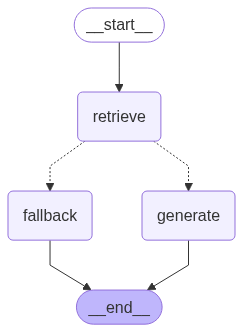

In [ ]:
app

In [ ]:
# --- Test Case 1: Relevant Question ---
print("--- RUNNING TEST CASE 1 ---")
question1 = "What are the two main stages of photosynthesis?"
inputs1 = {"question": question1}
result1 = app.invoke(inputs1)
print("\n--- FINAL ANSWER ---")
print(result1['question'])


print("\n\n================================\n\n")


# --- Test Case 2: Irrelevant Question ---
print("--- RUNNING TEST CASE 2 ---")
question2 = "Who was the first president of the United States?"
inputs2 = {"question": question2}
result2 = app.invoke(inputs2)
print("\n--- FINAL ANSWER ---")
print(result2['question'])

--- RUNNING TEST CASE 1 ---
---NODE: Retrieving Documents---
---NODE: Grading Documents---
---DECISION: Documents are relevant---
---NODE: Generating Answer---
---SUCCESS: Generated Answer---

--- FINAL ANSWER ---
The two main stages of photosynthesis are:

1. **Light‑Dependent Reactions** – occur in the thylakoid membranes and produce O₂, ATP, and NADPH.  
2. **Light‑Independent Reactions (Calvin Cycle)** – occur in the stroma and use ATP and NADPH to convert CO₂ into glucose.




--- RUNNING TEST CASE 2 ---
---NODE: Retrieving Documents---
---NODE: Grading Documents---
---DECISION: Documents are NOT relevant---
---NODE: Fallback - Answering without context---
---SUCCESS: Generated Fallback Answer---

--- FINAL ANSWER ---
I wasn’t able to locate this information in your specific course materials, so I’ll answer based on general knowledge.

The first President of the United States was **George Washington**, who served from 1789 to 1797.
